In [1]:
# 개발환경은 구글의 Colaboratory 를 사용하였습니다. 

In [2]:
# 필요한 라이브러리 불러오기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# uni-secom 데이터 불러오기 
raw_data = pd.read_csv('uci-secom.csv')

In [4]:
# uni-secom 데이터 프레임 확인  
raw_data.head()

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


# 결측치 처리 

열 별 결측치 비율을 오름차순으로 정렬하면 이상치 비율이 3.25%에서 바로 16.59%으로 넘어감을 확인함. 16.59% 만큼의 결측치를 대체하려면 1567개 중 260개를 대체해야 함. 대체를 할 경우 꽤 많은 값이 같은 값을 같게 됨. 따라서 대체의 의미가 없다고 판단하고 결측치 비율이 16.59% 이상인 열은 제거 진행. 


결과적으로, 한 열의 결측치 비율이 전체 행의 3.25% 이하(결측치가 51개 이하)인 열만 남기고 나머지 열은 제거. 


결측치 중앙값으로 대체 

In [5]:
# 열별 결측치 수 판별
null = []
Not_null = []
null = raw_data.isnull().sum()

In [6]:
# 결측치가 없는 열은 제거 안함 
for i in null.index:
    if null[i] == 0:
        Not_null.append(i)
null = null.drop(Not_null)

In [7]:
# 결측치가 51(3.25%)개 이하인 열은 제거 안함 
null_20 = []
for i in null.index:
    if null[i] < 52:
        null_20.append(i)
null = null.drop(null_20)

# 제거되는 열의 수 확인 
len(null)

52

In [8]:
# 결측치가 51(3.25%)개 이상인 열 제거 
data = raw_data.copy()
data = data.drop(null.index,axis=1)

In [9]:
# 열 제거 후, 남은 결측치 중간값으로 대체 
data.replace(np.nan, data.median(), inplace=True)

# 데이터에 결측치가 있는지 확인 
data.isnull().any().any()

False

In [10]:
# 결측치 제거 후 남은 열 
data.columns

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '577', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=540)

# 'Time' 변수 제거
'Time' 변수는 데이터가 기록된 시간을 의미하는 값으로, 반도체 공정의 데이터에서는 시계열적 요소를 고려하지 않아도 되기 때문에 이는 제거 진행

In [11]:
data = data.drop('Time', axis=1)

# 한 열에 하나의 값만 들어있는 열 제거
한 열이 모두 하나의 값을 갖는다면, 행의 특성을 설명하지 못하는 변수임. 

행의 특성을 반영하지 않는 변수는 의미없는 변수이므로 제거 진행.

In [12]:
# 한 열에 하나의 값만 들어있는 열 추출  
unique_columns = []
for i in data.columns:
    tmp =  data[i].unique() 
    if len(tmp) == 1:
        unique_columns.append(i)

# 제거되는 열 수 확인 
len(unique_columns)

116

In [13]:
# 한 열에 하나의 값만 들어있는 열 제거 
data = data.drop(unique_columns, axis=1)

In [14]:
# 열 제거 후 데이터 프레임 정보 확인 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 423 entries, 0 to Pass/Fail
dtypes: float64(422), int64(1)
memory usage: 5.1 MB


In [15]:
# 데이터 정규화를 위해 분리 
X = data.loc[:,'0':'589']
y = data.loc[:,'Pass/Fail']

# 데이터 정규화 
변수 축소를 하기 전, 모든 변수가 동일한 스케일(중요도)를 갖게 하기 위해 정규화 진행  

In [16]:
# 데이터 정규화를 위한 함수 불러오기 
from sklearn.preprocessing import MinMaxScaler

In [17]:
# MinMaxscaling 진행 
minmaxscaler = MinMaxScaler()
X = minmaxscaler.fit_transform(X)
X = pd.DataFrame(X)

# 변수 축소
대부분의 머신러닝 모델은 입력 데이터의 차원이 클 경우, 차원의 저주와 학습 속도가 저하되는 문제를 갖고 있음. 

이를 해결하기 위해 데이터에서 불필요한 Feature를 제거하는 변수 축소 진행.




*** 차원의 저주: 차원이 클수록 저차원일때보다 예측이 더 불안정해지는 문제 ***


변수 축소 방법으로 LGBM 알고리즘을 통한 변수 선택 방법 적용. 

변수 중요도를 명확히 파악 가능한 트리 기반의 변수 선택 방법인 LGBM 알고리즘 내재 방법 적용. 





In [18]:
feature_name = list(pd.DataFrame(X).columns)

# 뽑고 싶은 최대 변수 수 지정: 55라고 지정한 이유는 여러 값의 num_feats 적용 후, 적은 데이터셋으로도 높은 예측력을 보이는 수로 선택 
num_feats= 55

In [19]:
# LGBM 알고리즘을 통한 변수 선택 
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=55, norm_order=1, prefit=False, 

In [20]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

55 selected features


In [21]:
df_lgb = pd.DataFrame(X, columns=embeded_lgb_feature)
X_lgb = df_lgb.copy() 

In [22]:
# 최종 선택된 독립변수 데이터 셋 
X_lgb.head()

,0,9,19,20,25,31,45,54,60,63,67,74,77,81,92,93,106,108,110,113,115,123,142,145,157,160,168,173,201,223,228,237,238,240,241,251,252,255,262,267,270,312,328,336,353,356,364,372,374,386,402,411,413,414,419
0,0.469231,0.358362,0.242124,0.797675,0.398104,0.121293,0.411986,0.138291,0.221741,0.762021,0.349287,0.584689,0.469649,0.380564,0.804489,0.539474,0.522891,0.185512,0.746269,0.109093,0.598316,0.177496,0.231894,0.094044,0.687359,0.294118,0.044557,0.036098,0.117117,0.096591,0.000282,0.070859,0.019589,0.055231,0.037953,0.052696,0.337770,0.202104,0.042794,0.006250,0.023483,0.027914,0.082890,0.043740,0.155453,0.041580,0.014323,0.843543,0.053242,0.000000,0.229765,0.150986,0.112244,0.709375,0.151239
1,0.575003,0.228669,0.238978,0.712274,0.964903,0.139530,0.535243,0.151144,0.204983,0.833427,0.300238,0.601795,0.424601,0.301473,0.552208,0.533835,0.576019,0.166731,0.671642,0.113750,0.590733,0.195880,0.014149,0.117032,0.783361,0.218742,0.029844,0.024490,0.099099,0.160985,0.000393,0.095365,0.054403,0.093520,0.046519,0.135154,0.277853,0.195077,0.035214,0.005727,0.019084,0.026484,0.005664,0.036447,0.229751,0.039419,0.014288,0.130702,0.194921,0.000000,0.115285,0.102807,0.068396,0.753125,0.220339
2,0.308868,0.411832,0.238104,0.738940,0.989554,0.067069,0.408149,0.267903,0.175564,0.727359,0.288644,0.677510,0.673163,0.573214,0.658545,0.569549,0.553733,0.232081,0.776119,0.188148,0.575565,0.245008,0.188969,0.195402,0.712416,0.213394,0.012400,0.068836,0.117117,0.166667,0.000331,0.151976,0.056536,0.071542,0.057762,0.141570,0.284887,0.245936,0.035449,0.015173,0.032864,0.019624,0.072916,0.088241,0.172564,0.037459,0.025803,0.747295,0.192235,0.244275,0.983876,0.077769,0.050771,0.562500,0.589309
3,0.400385,0.359499,0.235237,0.724308,0.955045,0.068333,0.447084,0.270716,0.168451,0.750309,0.146849,0.674706,0.504473,0.241362,0.558569,0.507519,0.570761,0.279992,0.238806,0.234602,0.651403,0.331220,0.085132,0.071055,0.556166,0.173669,0.012400,0.052696,0.117117,0.195076,0.001153,0.054141,0.043154,0.059341,0.038230,0.198089,0.257655,0.254268,0.043215,0.015594,0.025210,0.011690,0.033513,0.042575,0.139495,0.052237,0.016615,0.104719,0.000000,0.000000,0.434376,0.055956,0.043312,0.662500,0.152542
4,0.471367,0.315131,0.234118,0.720752,0.949862,0.073974,0.328147,0.084682,0.350179,0.738046,0.153092,0.583567,0.672524,0.482834,0.725996,0.533835,0.513000,0.283059,0.417910,0.252299,0.514879,0.329319,0.067866,0.153605,0.516470,0.148714,0.035729,0.084313,0.076577,0.178030,0.000267,0.143427,0.017552,0.192557,0.031330,0.457338,0.204451,0.511249,0.021564,0.013180,0.025941,0.022761,0.026848,0.036276,0.162191,0.024435,0.015655,0.000000,0.750039,0.000000,0.138504,0.090288,0.069148,0.068750,0.152542


# 이상치 처리
조건2. 적용하여 이상치 처리.
 
fail과 pass의 이상치 수정 비율을 맞추기 위해 fail은 3.4의 weight를 주고, pass는 2의 weight 를 줘 이상치 탐지. 


이상치 탐지 후, boundary 값으로 이상치 대체.
boundary는 fail, pass 각각 적용한 이상치 탐지 기준점에 해당함. 



셀 단위 전체 셀 86,185개 중 1,847개 만큼 수정하였으며, 이는 전체 셀 중 2.14% 수정함을 의미함. 


pass 중 수정한 이상치 : fail 중 수정한 이상치 = 1718:129 = 93:7 비율을 맞춤. 

In [23]:
data_1 = pd.concat([X_lgb,y], axis=1)

In [24]:
data_1.index

RangeIndex(start=0, stop=1567, step=1)

In [25]:
from collections import Counter
def detect_outliers(df, n, features):
  outlier_indices_1 = []
  outlier_indices_2 = []
  c_1 = 0
  c_2 = 0
  for col in features:
    fraud_1 = df[df['Pass/Fail'] == 1][col]#Pass/Fail이 1인것만 받아들이기
    fraud_2 = df[df['Pass/Fail'] == -1][col] #Pass/Fail이 -1인것만 받아들이기
    Q1_1 = np.percentile(fraud_1.values, 25) #low boundary25
    Q1_2 = np.percentile(fraud_2.values, 25) #low boundary25
    Q3_1 = np.percentile(fraud_1.values, 75) #high boundary75
    Q3_2 = np.percentile(fraud_2.values, 75) #high boundary75
    IQR_1 = Q3_1 - Q1_1       #Low와 High의 간격
    IQR_2 = Q3_2 - Q1_2       #Low와 High의 간격
    outlier_step_1 = 3.4 * IQR_1       #37
    outlier_step_2 = 2 * IQR_2   #12
    outlier_index_1 = fraud_1[(fraud_1 < Q1_1 - outlier_step_1) | (fraud_1 > Q3_1 + outlier_step_1)].index
    outlier_index_2 = fraud_2[(fraud_2 < Q1_2 - outlier_step_2) | (fraud_2 > Q3_2 + outlier_step_2)].index
    outlier_indices_1.extend(outlier_index_1)
    outlier_indices_2.extend(outlier_index_2)
    if outlier_index_1.size != 0:
      for row in outlier_index_1:
        if df[col][row] > Q3_1 + outlier_step_1:
          df[col][row] =  Q3_1 + outlier_step_1
          c_1+=1
        else:
          df[col][row] = Q1_1 - outlier_step_1
          c_1+=1
    if outlier_index_2.size != 0:
      for row in outlier_index_2:
        if df[col][row] > Q3_2 + outlier_step_2:
          df[col][row] = Q3_2 + outlier_step_2
          c_2+=1
        else:
          df[col][row] = Q1_2 - outlier_step_2
          c_2+=1
  print('Fail 데이터에 대한 이상치 개수 비율 = ', c_1/(55 * df[df['Pass/Fail'] == 1][0].size)*100, '%')
  print(c_1)
  print('Pass 데이터에 대한 이상치 개수 비율 = ', c_2/(55 * df[df['Pass/Fail'] == -1][0].size)*100, '%')
  print(c_2)

In [26]:
detect_outliers(data_1, 0, data_1.columns)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to b

Fail 데이터에 대한 이상치 개수 비율 =  2.2552447552447554 %
129
Pass 데이터에 대한 이상치 개수 비율 =  2.1350897905921826 %
1718


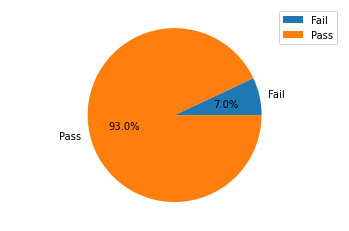

In [27]:
# pass, fail의 수정된 이상치 비율
import matplotlib.pyplot as plt

size = [129, 1718]
label = ['Fail','Pass']
plt.axis('equal')
plt.pie(size, labels=label, autopct='%.1f%%')
plt.legend()
plt.show()

# 모델링 
앙상블 기법, 보팅은 오버피팅을 방지해주는 효과가 있어 채택. 


In [28]:
# 모델링을 위해 X,y 분리 
X = data_1.iloc[:,0:-1]
y = data_1.iloc[:,-1]

In [29]:
# 성능지표 함수
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test,pred, pred_prob):
  acc = accuracy_score(y_test,pred)
  pre = precision_score(y_test,pred)
  re = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)
  auc = roc_auc_score(y_test,pred_prob)

  return acc,pre,re,f1,auc

In [30]:
# 성능지표 함수
def print_clf_eval(y_test,pred, pred_prob):
  confusion = confusion_matrix(y_test,pred)
  acc,pre,re,f1,auc = get_clf_eval(y_test,pred, pred_prob)

  print('=>오차행렬')
  print(confusion)
  print('=============')
  print('정확도(acc) : {0:.4f}, 정밀도(pre) : {1:.4f}'.format(acc,pre))
  print('재현율(re) : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re,f1,auc))

In [31]:
# 앙상블 학습 후 오차행렬 확인
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.model_selection import cross_validate
# VotingClassifier
from sklearn.ensemble import VotingClassifier

# ensemble 할 model 정의
models = [
    ('rfc', RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=1000)),
    ('lgbm', LGBMClassifier(n_estimators=1000, num_leaves=32, n_jobs=-1,boost_from_average=False)),
    ('xgb', XGBClassifier(n_estimators=500, learning_rate = 0.1)),
    ('etc',ExtraTreesClassifier(n_estimators=100, random_state=13)), 
    ('bc', BaggingClassifier(base_estimator=XGBClassifier(),n_estimators=10, random_state=13))
    ]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=13,stratify=y)
soft_vote  = VotingClassifier(models, voting='soft')
soft_vote.fit(X_train, y_train)
pred_proba_1 = soft_vote.predict_proba(X_test)[:,1]
soft_vote_pred = soft_vote.predict(X_test)
auc_test = roc_auc_score(y_test, pred_proba_1)
print('auc_test =', auc_test)
print('')
print_clf_eval(y_test,soft_vote_pred,pred_proba_1)

auc_test = 0.9437672679993498

=>오차행렬
[[293   0]
 [ 17   4]]
정확도(acc) : 0.9459, 정밀도(pre) : 1.0000
재현율(re) : 0.1905, F1 : 0.3200, AUC : 0.9438


In [32]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.model_selection import cross_validate

# VotingClassifier
from sklearn.ensemble import VotingClassifier

# ensemble 할 model 정의
models = [
    ('rfc', RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=1000)),
    ('lgbm', LGBMClassifier(n_estimators=1000, num_leaves=32, n_jobs=-1,boost_from_average=False)),
    ('xgb', XGBClassifier(n_estimators=500, learning_rate = 0.1)),
    ('etc',ExtraTreesClassifier(n_estimators=100, random_state=13)), 
    ('bc', BaggingClassifier(base_estimator=XGBClassifier(),n_estimators=10, random_state=13))
    ]

# 모델 성능 평가를 위한 Radom_state 지정 
random_state = []
for j in range(1,101): 
    random_state.append(j)
ai = []

# AUC_ROC SCORE 평균 확인 
for rand in random_state:
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state= rand,stratify=y)
  soft_vote  = VotingClassifier(models, voting='soft')
  soft_vote.fit(X_train, y_train)
  pred_proba_1 = soft_vote.predict_proba(X_test)[:,1]
  auc_test = roc_auc_score(y_test, pred_proba_1)
  print('random_state=', rand,'  ' ,'auc_test =', auc_test)
  print('')
  ai.append(float(auc_test))
print(ai)
print(sum(ai)/len(ai))

random_state= 1    auc_test = 0.952055907687307

random_state= 2    auc_test = 0.9335283601495205

random_state= 3    auc_test = 0.9440923126929953

random_state= 4    auc_test = 0.9606695920689095

random_state= 5    auc_test = 0.8953356086461889

random_state= 6    auc_test = 0.9289777344384853

random_state= 7    auc_test = 0.9128880221030391

random_state= 8    auc_test = 0.9226393629124005

random_state= 9    auc_test = 0.8860718348772956

random_state= 10    auc_test = 0.8542174549000486

random_state= 11    auc_test = 0.9258898098488542

random_state= 12    auc_test = 0.9858605558264262

random_state= 13    auc_test = 0.9437672679993498

random_state= 14    auc_test = 0.9211766617909962

random_state= 15    auc_test = 0.9195514383227694

random_state= 16    auc_test = 0.964082561352186

random_state= 17    auc_test = 0.9052494718023728

random_state= 18    auc_test = 0.9696083211441573

random_state= 19    auc_test = 0.9561189663578742

random_state= 20    auc_test = 0.957419145